
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [87]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sbn

In [3]:
#Dropout: 5%, 15%, 25%, 35%, and 50%
DROPOUT = 0.10

#Learning rate: 5e-4, 1e-3, 5e-3, 1e-2
LEARNING_RATE = 5e-5

In [4]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModel.from_pretrained("xlm-roberta-large")

In [5]:
df = pd.read_csv('../datasets/b2w_preprocessed.csv')

In [6]:
df.head(3)

,review_text,rating
0,recebi o produto antes do prazo mas veio com d...,0
1,nao compra este produto pois o mesmo veio com ...,0
2,tive azar pois o produto nao ligou tive que en...,0


In [9]:
print(f'{df.shape[0]} instancias, {df.shape[1]} classes')

71516 instancias, 2 classes


#### Dividindo dataset em dois batchs, 50% cada

In [16]:
reviews_batch_01, reviews_batch_02, labels_batch_01, labels_batch_02 = train_test_split(df['review_text'], df['rating'], test_size=0.5, random_state=42)

In [17]:
print(f'batch_01: {reviews_batch_01.shape[0]} instancias')
print(f'batch_02: {reviews_batch_02.shape[0]} instancias')

batch_01: 35758 instancias
batch_02: 35758 instancias


#### Quantidade de avaliações positivas e negativas no batch_01

In [9]:
labels_batch_01.value_counts()

rating
1    3419
0    3391
Name: count, dtype: int64

In [7]:
reviews = df['review_text']
labels = df['rating']

#### Tokenização e geração dos embeddings
- Este processo pode demorar alguns instantes para ser concluído

In [8]:
embeddings = []
for review in tqdm((reviews),desc='Processing'):
    inputs = tokenizer(str(review), return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        output = model(**inputs)
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())

Processing: 100%|██████████| 71516/71516 [7:05:24<00:00,  2.80it/s]   


In [9]:
embeddings_array = np.vstack(embeddings)

In [10]:
print(f'{embeddings_array.shape[0]} embeddings de {embeddings_array.shape[1]} dimensões')

71516 embeddings de 1024 dimensões


#### Feature based 1

In [89]:
additional_features = np.array([[len(str(review).split())] for review in reviews_batch_02])

In [90]:
print(embeddings_array.shape)
print(additional_features.shape)

(71516, 1024)
(35758, 1)


#### Combinando embeddings_array e additional_features

In [41]:
#combined_features = np.hstack((embeddings_array, additional_features))

#### Dividindo dataset treino e teste

In [91]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_array, labels, test_size=0.2, random_state=42)

In [92]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [93]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

#### Arquitetura rede neural MLP

In [94]:
model = Sequential([
    Dense(24, activation='relu', input_dim=X_train_tensor.shape[1]),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 24)                24600     
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 24,625
Trainable params: 24,625
Non-trainable params: 0
_________________________________________________________________


In [95]:
def load_weights_from_hdf5(model, weight_path):
    model.load_weights(weight_path)
    return model

In [96]:
tlm_gran_weights_path = '../weights/tlm_gran_weights.hdf5'
model = load_weights_from_hdf5(model, tlm_gran_weights_path)

In [97]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

#### Cross-validation

In [98]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

#### Ajustando path para salvar os pesos

In [99]:
#CHECKPOINT=ModelCheckpoint(filepath='../weights/tlm_gran_weights.hdf5', verbose=0, save_best_only=True)
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [EARLY_STOP]

#### Treinamento do modelo

In [104]:
fold = 0

train_losses = []
train_accuracies = []
train_f1_scores = []

val_losses = []
val_accuracies = []
val_f1_scores = []

for train_indices, val_indices in tqdm((kf.split(embeddings_array)),desc='Processing'):
    fold+=1
    print(f'fold = {fold}')
    
    X_train_fold = embeddings_array[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = embeddings_array[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
    
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=5, 
        batch_size=32, 
        verbose=0,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS,
    )
    
    # ------------------------------------------------------------------------
    
    # train y prediction
    y_pred_train = model.predict(X_train_fold_tensor)
    y_pred_train_binary = np.round(y_pred_train)
    
    # train losses
    train_losses.append(model_history.history['loss'])
    
    # train accuracies
    train_accuracies.append(model_history.history['accuracy'])
    
    # train f1 scores
    train_f1_score = f1_score(y_train_fold, y_pred_train_binary)
    train_f1_scores.append(train_f1_score)
    
    # ------------------------------------------------------------------------
    
    # val y prediction
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    # val losses
    val_losses.append(model_history.history['val_loss'])
    
    # val accuracies
    val_accuracies.append(model_history.history['val_accuracy'])
    
    # val f1 scores
    val_f1_score = f1_score(y_val_fold_tensor, y_pred_val_binary)
    val_f1_scores.append(val_f1_score)
    
print('Finished!')

Processing: 0it [00:00, ?it/s]

fold = 1
224/224 [==============================] - 0s 782us/step


Processing: 1it [00:13, 13.75s/it]

fold = 2
224/224 [==============================] - 0s 771us/step


Processing: 2it [00:29, 14.90s/it]

fold = 3
224/224 [==============================] - 0s 760us/step


Processing: 3it [00:45, 15.48s/it]

fold = 4
224/224 [==============================] - 0s 770us/step


Processing: 4it [01:09, 18.61s/it]

fold = 5
224/224 [==============================] - 0s 807us/step


Processing: 5it [01:22, 16.79s/it]

fold = 6
224/224 [==============================] - 0s 841us/step


Processing: 6it [01:35, 15.56s/it]

fold = 7
224/224 [==============================] - 0s 784us/step


Processing: 7it [01:50, 15.14s/it]

fold = 8
224/224 [==============================] - 0s 983us/step


Processing: 8it [02:09, 16.67s/it]

fold = 9
224/224 [==============================] - 0s 1ms/step


Processing: 9it [02:23, 15.83s/it]

fold = 10
224/224 [==============================] - 0s 858us/step


Processing: 10it [02:39, 15.92s/it]

Finished!


In [117]:
train_mean_loss = np.mean([np.mean(train_loss) for train_loss in train_losses])
train_mean_acc = np.mean([np.mean(train_acc) for train_acc in train_accuracies])

print(f'mean train loss: {np.mean(train_mean_loss)}')
print(f'mean train acc: {np.mean(train_mean_acc)}')
print(f'mean train f1 score: {np.mean(train_f1_scores)}')

print('-'*80)

val_mean_loss = np.mean([np.mean(val_loss) for val_loss in val_losses])
val_mean_acc = np.mean([np.mean(val_acc) for val_acc in val_accuracies])

print(f'mean val loss: {np.mean(val_mean_loss)}')
print(f'mean val acc: {np.mean(val_mean_acc)}')
print(f'mean val f1 score: {np.mean(val_f1_scores)}')

mean train loss: 0.1104143289476633
mean train acc: 0.9620767042040825
mean train f1 score: 0.9631446159618837
--------------------------------------------------------------------------------
mean val loss: 0.10674292992800474
mean val acc: 0.963113189637661
mean val f1 score: 0.9625838939246663


In [107]:
graph_path = './graphs/11_tlm_gran_finetuning/'

def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(f'{graph_path}train_test_{metric}.png')
    plt.show()
    
def plot_train_folds(history, metric):
    plt.figure(figsize=(10, 6))
    for fold_num, fold_loss in enumerate(history):
        plt.plot(fold_loss, label=f'Fold {fold_num+1}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Training {metric}')
    plt.title(f'Training {metric} per Epoch for Each Fold')
    plt.legend()
    plt.savefig(f'{graph_path}train_folds_{metric}.png')
    plt.show()
    
def plot_confunsion_matrix(cm):
    plt.figure(figsize=(6,4))
    sbn.heatmap(cm, annot=True, linewidth=0.2, annot_kws={'size':12}, fmt='.0f')
    plt.title("Matriz de Confusão", fontsize=12)
    plt.xlabel('Real')
    plt.ylabel('Predito')
    plt.savefig(f'{graph_path}test_conf_matrix.png')
    plt.show()

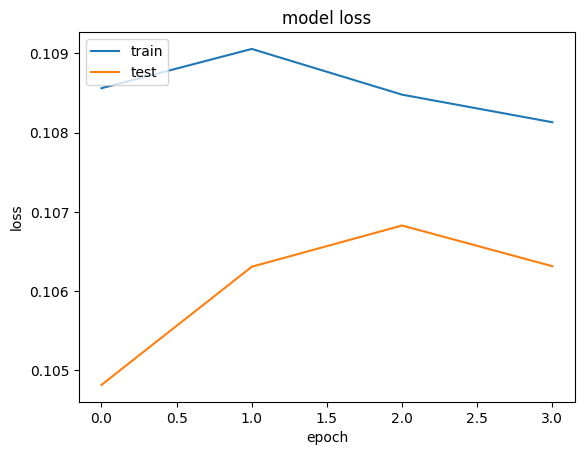

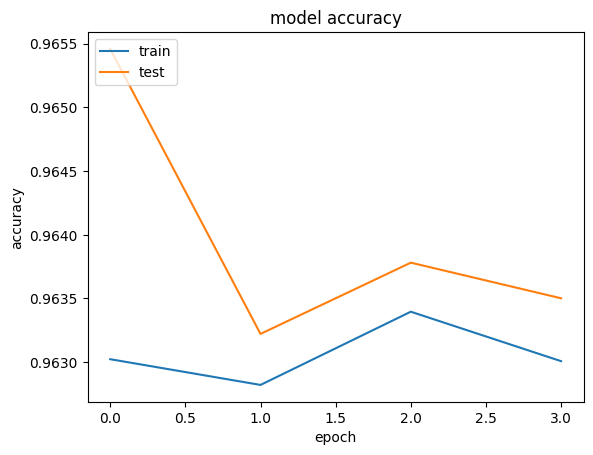

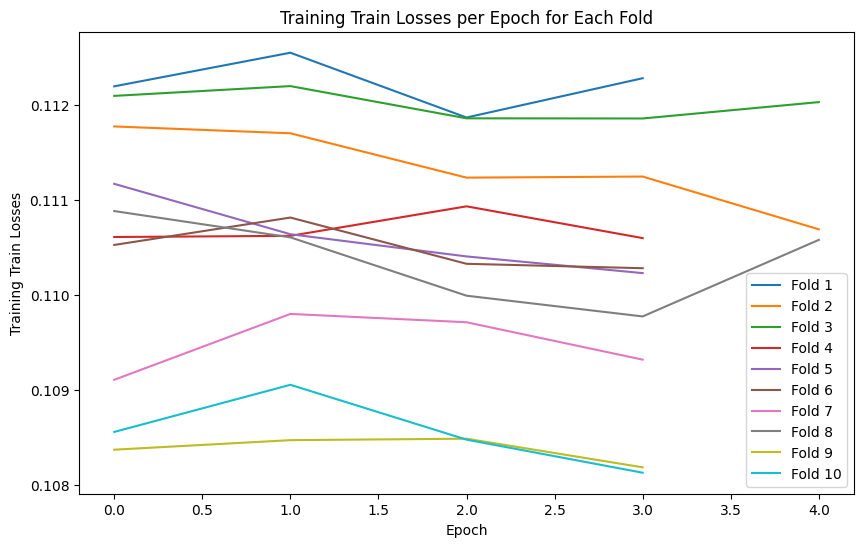

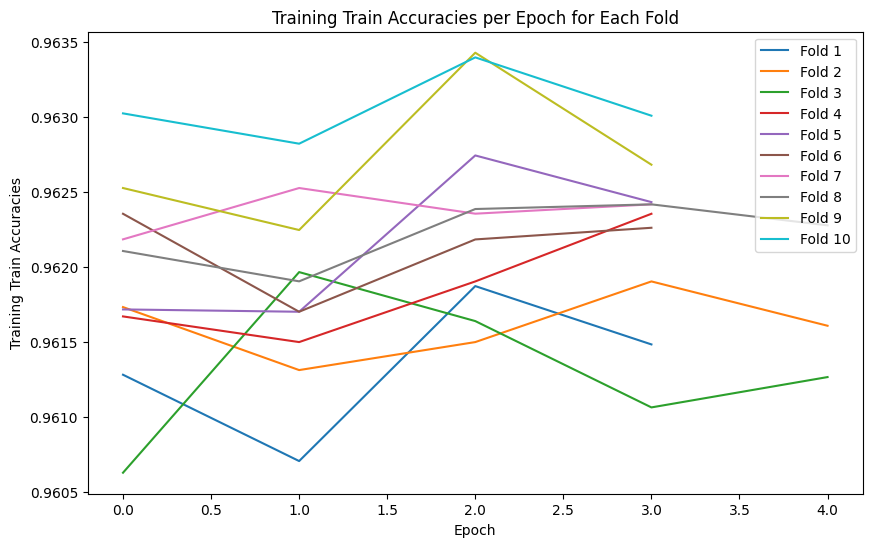

In [108]:
plot_eval_metrics(model_history, 'loss')
plot_eval_metrics(model_history, 'accuracy')
plot_train_folds(train_losses, 'Train Losses')
plot_train_folds(train_accuracies, 'Train Accuracies')

In [109]:
predict = np.round(model.predict(X_val_fold))

224/224 [==============================] - 0s 792us/step


In [110]:
accuracy = accuracy_score(y_val_fold, predict)
accuracy

0.96350160816669

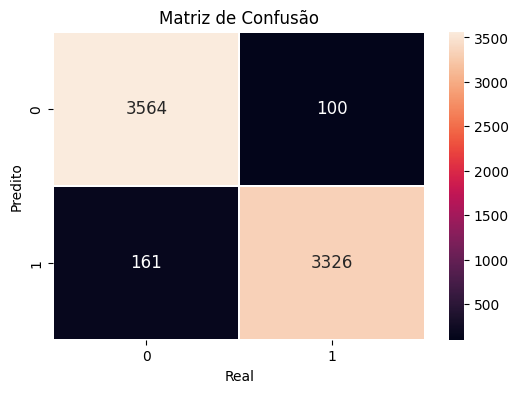

In [111]:
cm = confusion_matrix(y_val_fold, predict)
plot_confunsion_matrix(cm)